In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2

from imgaug import augmenters as iaa
import imgaug as ia
import glob
import pickle

import warnings 
warnings.filterwarnings("ignore")

In [2]:
segmentation_train_dir="/root/ye/Data/Indian-Diabetic/Segmentation/Groundtruths/training/"
original_train_dir="/root/ye/Data/Indian-Diabetic/Segmentation/Original-Images/training/"

segmentation_val_dir="/root/ye/Data/Indian-Diabetic/Segmentation/Groundtruths/testing/"
original_val_dir="/root/ye/Data/Indian-Diabetic/Segmentation/Original-Images/testing//"
#images_list=glob.glob(DATA_DIR+"*.tif")

WORK_DIR="/root/ye/Project/DL_MODUEL/Keras/Object-Detection/Mask_RCNN/Indian-Diabetic/logs/"

In [3]:
sys.path.append("..")
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from keras.callbacks import  LearningRateScheduler
import keras.backend as K

Using TensorFlow backend.


In [4]:
def get_tif_fps(tif_dir,_class=None):
    if _class is None:
        tif_fps=glob.glob(tif_dir+"/*.tif")
    else:
        tif_fps=glob.glob(tif_dir+_class+"/*.tif")
    return list(set(tif_fps))

def get_tif_imageid(tif_fps):
    tif_fps=os.path.basename(tif_fps)
    tif_part=tif_fps.split("_")
    image_id=tif_part[0]+"_"+tif_part[1]
    class_id=tif_part[2].split(".")[0]
    return image_id,class_id


def segmentation_to_original(image_id,original_dir):
    img_path=image_id+".jpg"
    img_path=original_dir+img_path
    #imgs=get_tif_fps(original_dir,".jpg")
    return img_path


def class_mask(segmentation_dir,_class):
    
    if not isinstance(_class,list):
        _class=[_class]
    #image_mask={fps:[] for fps in _class}
    image_id={fps:[] for fps in _class}
    mask_path={fps:[] for fps in _class}
    for ann in _class:
        path=os.path.join(segmentation_dir,ann)
        fps=get_tif_fps(path)
        for seg in fps:
            #mask=cv2.imread(seg,0)
            idx,_=get_tif_imageid(seg)
            #mask=np.reshape(mask,[mask.shape[0],mask.shape[1],1])
            #image_mask[ann].append(mask)
            image_id[ann].append(idx)
            mask_path[ann].append(seg)

    return image_id,mask_path


def annotation(original_dir,segmentation_dir,_class):
    
    Annotation=[]
    image_ids,mask_paths=class_mask(segmentation_dir,_class)
    for image_id,mask_path in zip(image_ids[_class],mask_paths[_class]):
        image_path=segmentation_to_original(image_id,original_dir)
        Annotation.append({"classes":_class,"path":image_path,"mask_path":mask_path})
    return Annotation
            

    


augmentation = iaa.SomeOf((0, 3), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)],
             ),
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])


sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


In [5]:
class DetectorConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "IDRiD"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    TRAIN_ROIS_PER_IMAGE = 32
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.3
    LEARNING_RATE=0.00001
    WEIGHT_DECAY=0.001
    VALIDATION_STEPS=100
    
config=DetectorConfig()
config.display()


class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self,original_dir,segmentation_dir,_class):
        super().__init__(self)
        
        # Add classes
        #self.add_class("IDRiD",0,"BG")
        self.add_class("IDRiD",1,_class)
        height,width=2848,4288
   
        image_annotations=annotation(original_dir,segmentation_dir,_class)
        # add images 
        for i, fp in enumerate(image_annotations):
            classes = fp["classes"]
            path=fp["path"]
            mask=fp["mask_path"]
            self.add_image('IDRiD', image_id=i, path=path, mask=mask,
                           classes=classes, height=height, width=width)
            
    def image_reference(self, image_id):
        assert image_id in self.image_ids
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image=cv2.imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        classes=info["classes"]  # consistent with mask
        classes=classes if isinstance(classes,list) else [classes]
        
        mask = np.zeros([info["height"],info["width"],len(classes)],dtype=np.int32)
        class_ids = np.zeros((len(classes)), dtype=np.int32)
        #class_ids = np.array([self.class_names.index(s[0]) for s in classes])
        msk=cv2.imread(info["mask"],0)
        for i,c in enumerate(classes):
            mask[:,:,i]=msk
            class_ids[i]=1
        return mask.astype(np.bool), class_ids.astype(np.int32)
 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  1e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [8]:
#_Annotation=annotation(original_train_dir,segmentation_train_dir,"SoftExudates")
dataset_train=DetectorDataset(original_train_dir,segmentation_train_dir,"HardExudates")
dataset_train.prepare()

dataset_val=DetectorDataset(original_val_dir,segmentation_val_dir,"HardExudates")
dataset_val.prepare()

image_id  43 /root/ye/Data/Indian-Diabetic/Segmentation/Original-Images/training/IDRiD_15.jpg
image                    shape: (2848, 4288, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2848, 4288, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  307.00000  max: 2123.00000  int32


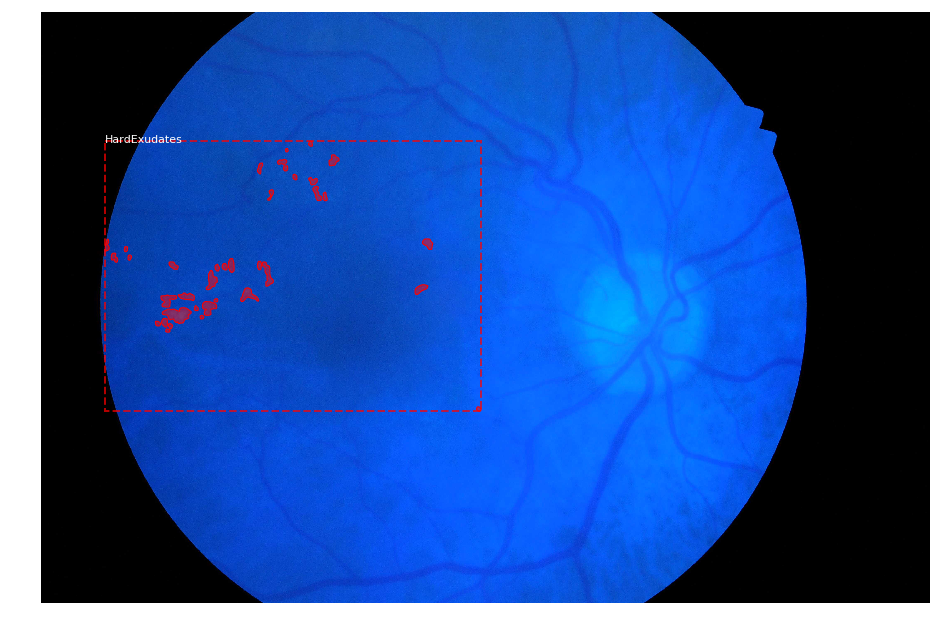

In [12]:
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
msk, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(msk)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", msk)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, msk, class_ids, dataset_train.class_names)

In [ ]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE="resnet50"

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=WORK_DIR)

MODEL_PATH="./checkpoint/hardexudates20190104T1105/mask_rcnn_hardexudates_0010.h5"
#MODEL_PATH="./checkpoints/mask_rcnn_idrid_101-0050.h5"
# Load trained weights
print("Loading weights from ",MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights from  ./checkpoint/hardexudates20190104T1105/mask_rcnn_hardexudates_0010.h5


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


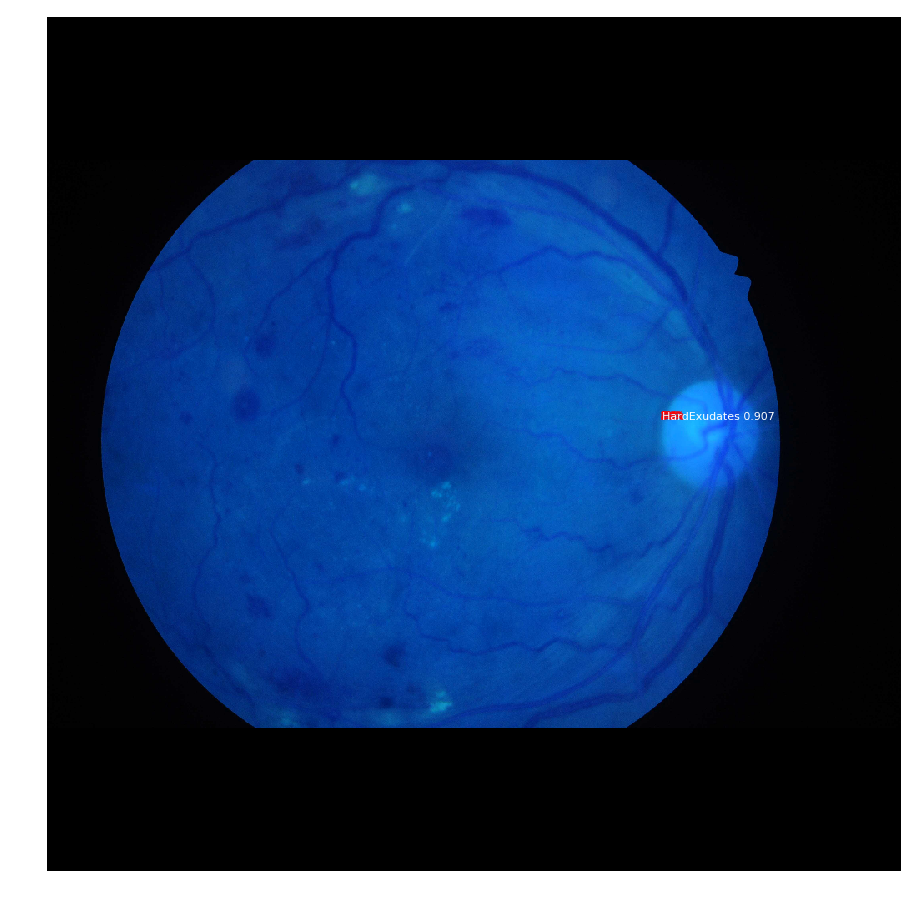

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])